# Install Transformers Library

In [37]:
!pip install transformers

In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config


# specify GPU
device = torch.device("cuda")

In [39]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Dataset

In [40]:
df = pd.read_excel("/content/gdrive/MyDrive/BERT fine tuning/Dataset/small_dataset2.xlsx")
df.head()

,class,Symptom Severity,Delusion Score,Text
0,control,0,0,"When i was a little kid um i used to ride, um..."
1,patient,69,24,"Well, i was at um kings, xxx, one pacific tim..."
2,patient,35,1,Um my ideal day would be being able to get to...
3,control,0,0,The perfect most ideal day for me would be um...
4,control,0,0,Xxx one morning i was working for westchester...


In [41]:
df.shape

(431, 4)

In [42]:
df['class'] = df['class'].replace(['patient','control'],[0,1])

In [43]:
# check class distribution
df['class'].value_counts(normalize = True)

1    0.545244
0    0.454756
Name: class, dtype: float64

# Split train dataset into train, validation and test sets

In [44]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Text'].astype('str'), df['class'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['class'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [45]:
# Load the GPT tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
# import GPT pretrained model
gpt_config = GPT2Config.from_pretrained('gpt2', num_classes=2, pad_token=tokenizer.eos_token, pad_token_id=tokenizer.eos_token_id)
gpt = GPT2ForSequenceClassification.from_pretrained('gpt2', config=gpt_config)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
tokenizer.pad_token = tokenizer.eos_token
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [47]:
# output
print(sent_id)

{'input_ids': [[5661, 318, 257, 275, 861, 2746, 11808, 50256, 50256, 50256], [732, 481, 3734, 12, 83, 1726, 257, 275, 861, 2746]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

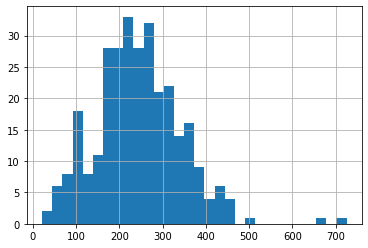

In [48]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [49]:
max_seq_len = 120

In [50]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [51]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist(), dtype=torch.float32)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist(), dtype=torch.float32)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist(), dtype=torch.float32)

# Create DataLoaders

In [52]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [53]:
# # freeze all the parameters
# for name, param in gpt.named_parameters():
#   param.requires_grad = False

# freeze all the parameters
for name, param in gpt.named_parameters():
    if name in ['transformer.ln_f.weight', 'transformer.ln_f.bias', 'score.weight']:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define Model Architecture

In [54]:
class GPT_Arch(nn.Module):

    def __init__(self, gpt):
      
      super(GPT_Arch, self).__init__()

      self.gpt = gpt

      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      x = self.gpt(input_ids=sent_id, attention_mask=mask)

      return self.softmax(x[0])

In [55]:
# pass the pre-trained BERT to our define architecture
model = GPT_Arch(gpt)

# push the model to GPU
model = model.to(device)

In [56]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-4)

# Find Class Weights

In [57]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.09854015 0.91768293]


In [58]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 40

# Fine-Tune BERT

In [59]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels.long())

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [60]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels.long())

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [61]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 40

Evaluating...

Training Loss: 4.964
Validation Loss: 4.191

 Epoch 2 / 40

Evaluating...

Training Loss: 2.104
Validation Loss: 0.763

 Epoch 3 / 40

Evaluating...

Training Loss: 0.914
Validation Loss: 0.648

 Epoch 4 / 40

Evaluating...

Training Loss: 0.866
Validation Loss: 0.771

 Epoch 5 / 40

Evaluating...

Training Loss: 0.714
Validation Loss: 0.635

 Epoch 6 / 40

Evaluating...

Training Loss: 0.672
Validation Loss: 0.816

 Epoch 7 / 40

Evaluating...

Training Loss: 0.640
Validation Loss: 0.712

 Epoch 8 / 40

Evaluating...

Training Loss: 0.620
Validation Loss: 0.863

 Epoch 9 / 40

Evaluating...

Training Loss: 0.630
Validation Loss: 0.757

 Epoch 10 / 40

Evaluating...

Training Loss: 0.576
Validation Loss: 0.868

 Epoch 11 / 40

Evaluating...

Training Loss: 0.583
Validation Loss: 0.772

 Epoch 12 / 40

Evaluating...

Training Loss: 0.565
Validation Loss: 0.793

 Epoch 13 / 40

Evaluating...

Training Loss: 0.548
Validation Loss: 0.848

 Epoch 14 / 40

Eval

# Load Saved Model

In [62]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Get Predictions for Test Data

In [63]:
# get predictions for test data
model.eval()
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [64]:
preds

array([[-0.29989222, -1.3505336 ],
       [-1.477327  , -0.2590907 ],
       [-1.0914407 , -0.4090703 ],
       [-1.9261568 , -0.15748115],
       [-0.6045    , -0.790424  ],
       [-0.2527682 , -1.4990059 ],
       [-0.8132309 , -0.5859499 ],
       [-0.41618964, -1.0775024 ],
       [-0.188175  , -1.7629955 ],
       [-0.36856803, -1.1767603 ],
       [-0.79721844, -0.59889305],
       [-1.3270549 , -0.30823502],
       [-0.6476703 , -0.74079114],
       [-0.9612886 , -0.481914  ],
       [-0.44877455, -1.0172445 ],
       [-0.40642515, -1.0966948 ],
       [-0.5155821 , -0.90919834],
       [-0.9764785 , -0.47262317],
       [-1.0045941 , -0.45601124],
       [-0.33490372, -1.2566952 ],
       [-0.39323717, -1.1235261 ],
       [-0.65355414, -0.7343727 ],
       [-0.77172387, -0.62029755],
       [-0.84870505, -0.5585617 ],
       [-0.49364728, -0.9426244 ],
       [-0.8285919 , -0.5738786 ],
       [-0.84173113, -0.56381124],
       [-0.35590765, -1.2057656 ],
       [-0.71109015,

In [65]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

         0.0       0.50      0.60      0.55        30
         1.0       0.59      0.49      0.53        35

    accuracy                           0.54        65
   macro avg       0.54      0.54      0.54        65
weighted avg       0.55      0.54      0.54        65



In [66]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0.0,18,12
1.0,18,17
